In [1]:
setwd('E:/notebook/miMatch')
library(vegan)
library(ape)
library(ggplot2)
library(grid)
library(plyr)
library(dplyr)
library(multcomp)
library(patchwork)

Loading required package: permute

Loading required package: lattice

This is vegan 2.6-2

Warning message:
"package 'ggplot2' was built under R version 4.2.2"
Warning message:
"package 'plyr' was built under R version 4.2.2"

Attaching package: 'dplyr'


The following objects are masked from 'package:plyr':

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Loading required package: mvtnorm

Loading required package: survival

Loading required package: TH.data

Loading required package: MASS


Attaching package: 'MASS'


The following object is masked from 'package:dplyr':

    select



Attaching package: 'TH.data'


The following object is masked from 'package:MASS':

    geyser



Attaching package: 'patchwork'


The following object is masked from 'package:MASS':

    area




# IBD micro data difference

In [2]:
data<-read.csv("Label/fenzu.csv",stringsAsFactors = F,row.names = 1)
IBD<-data[which(data$condition2=="IBD"),]
rownames(IBD)
path = "E:/notebook/miMatch/Temp"
fileName = dir(path)
fileName = fileName[which(fileName%in%rownames(IBD))]
fileName

[1] "27"   "36"   "38"   "48_1" "59"

[1] "27"   "36"   "38"   "48_1" "59"

In [3]:
filePath <- sapply(fileName, function(x){ 
  paste(path,x,"Microbiome.csv",sep="/")})   
data <- lapply(filePath, function(x){
  read.csv(x, header=T,row.names = 1)})  
microdata=data[[1]]
for (i in 2:length(data)) {
  microdata<-merge(microdata,data[[i]],all=T)
}

rownames(microdata)=c(rownames(data[[1]]),rownames(data[[2]]),rownames(data[[3]]),rownames(data[[4]]),rownames(data[[5]]))
#write.csv(microdata,"Temp/IBDmicrodata.csv",row.names = T)

In [4]:
metadata<-read.csv("Temp/IBDmetadata.csv",stringsAsFactors = F)
colnames(metadata)
microdata<-read.csv("Temp/IBDmicrodata.csv",row.names = 1,stringsAsFactors = F)
microdata<-as.data.frame(t(na.omit(t(microdata)))) 
PSMlabel<-read.csv("Temp/IBDMatchedLabel.csv",stringsAsFactors = F)  

[1] "study_name"                 "sample_id"                 
 [3] "subject_id"                 "body_site"                 
 [5] "antibiotics_current_use"    "study_condition"           
 [7] "disease"                    "age"                       
 [9] "age_category"               "gender"                    
[11] "country"                    "non_westernized"           
[13] "sequencing_platform"        "DNA_extraction_kit"        
[15] "PMID"                       "number_reads"              
[17] "number_bases"               "minimum_read_length"       
[19] "median_read_length"         "NCBI_accession"            
[21] "curator"                    "BMI"                       
[23] "family"                     "days_from_first_collection"
[25] "family_role"                "location"                  
[27] "visit_number"               "disease_subtype"           
[29] "treatment"                  "disease_location"          
[31] "calprotectin"               "HBI"                       
[33] "SCCAI"                      "remission"                 
[35] "mgs_richness"               "ferm_milk_prod_consumer"

# PCoA

## micro diff between cases and controls

### unmatched cohort

In [5]:
groups <- data.frame(metadata$sample_id,metadata$study_condition)
colnames(groups) <- c("V1","V2")

data <- vegdist(microdata)
pcoa<- pcoa(data, correction = "none", rn = NULL)
PC1 = pcoa$vectors[,1]
PC2 = pcoa$vectors[,2]
plotdata <- data.frame(groups$V1,PC1,PC2,groups$V2)
colnames(plotdata) <-c("sample","PC1","PC2","Group")
pc1 <-floor(pcoa$values$Relative_eig[1]*100)
pc2 <-floor(pcoa$values$Relative_eig[2]*100)
plotdata$Group <- factor(plotdata$Group,levels = c("control","IBD"))

In [6]:
yf <- plotdata
aggregate(yf$PC1,by=list(yf$Group),mean)
aggregate(yf$PC2,by=list(yf$Group),mean)
plotdata$pair[which(plotdata$Group=="control")]<-1:796
plotdata$pair[which(plotdata$Group=="IBD")]<-797:2526
cp<-data.frame(sample="mean_control",
               PC1=0.0141,PC2=-0.00204,Group="control",
               pair=1:796)
ip<-data.frame(sample="mean_ibd",
               PC1=-0.00647,PC2=0.000938,Group="IBD",
               pair=797:2526)
plotdata<-rbind(plotdata,cp,ip)

yd1 <- yf %>% group_by(Group) %>% summarise(Max = max(PC1))
yd2 <- yf %>% group_by(Group) %>% summarise(Max = max(PC2))

yd1$Max <- yd1$Max + max(yd1$Max)*0.1
yd2$Max <- yd2$Max + max(yd2$Max)*0.1
fit1 <- aov(PC1~Group,data = plotdata)
tuk1<-glht(fit1,linfct=mcp(Group="Tukey"))
res1 <- cld(tuk1,alpah=0.05)
fit2 <- aov(PC2~Group,data = plotdata)
tuk2<-glht(fit2,linfct=mcp(Group="Tukey"))
res2 <- cld(tuk2,alpah=0.05)
test <- data.frame(PC1 = res1$mcletters$Letters,PC2 = res2$mcletters$Letters,
                   yd1 = yd1$Max,yd2 = yd2$Max,Group = yd1$Group)
test$Group <- factor(test$Group,levels = c("control","IBD"))
cbbPalette=c("#5175A4","#D94E48")

Group.1,x
<fct>,<dbl>
control,0.014062686
IBD,-0.006470461


Group.1,x
<fct>,<dbl>
control,-0.0020393460
IBD,0.0009383349


In [7]:
p1 <- ggplot(yf,aes(Group,PC1)) +
  geom_boxplot(aes(fill = Group)) +
  geom_text(data = test,aes(x = Group,y = yd1,label = PC1),
            size = 7,color = "black",fontface = "bold") +
  coord_flip() +
  scale_fill_manual(values=cbbPalette) +
  theme_bw()+
  theme(axis.ticks.length = unit(0.4,"lines"), 
        axis.ticks = element_line(color='black'),
        axis.line = element_line(colour = "black"), 
        axis.title.x=element_blank(),
        axis.title.y=element_blank(),
        axis.text.y=element_text(colour='black',size=20,face = "bold"),
        axis.text.x=element_blank(),
        legend.position = "none")

In [8]:
p3 <- ggplot(yf,aes(Group,PC2)) +
  geom_boxplot(aes(fill = Group)) +
  geom_text(data = test,aes(x = Group,y = yd2,label = PC2),
            size = 7,color = "black",fontface = "bold") +
  scale_fill_manual(values=cbbPalette) +
  theme_bw()+
  theme(axis.ticks.length = unit(0.4,"lines"), 
        axis.ticks = element_line(color='black'),
        axis.line = element_line(colour = "black"), 
        axis.title.x=element_blank(),
        axis.title.y=element_blank(),
        axis.text.x=element_text(colour='black',size=20,angle = 45,
                                 vjust = 1,hjust = 1,face = "bold"),
        axis.text.y=element_blank(),
        legend.position = "none")

hlpoint<-plotdata[c(2527,5052),]

In [9]:
p2<-ggplot(plotdata, aes(PC1, PC2)) +
  geom_point(aes(fill=Group),size=4,pch =23)+
  geom_line(aes(group = pair,color=Group),alpha=0.3) +
  geom_point(data=hlpoint,aes(fill=Group),size=8,pch =21)+
  scale_fill_manual(values=cbbPalette,name = "Group")+
  scale_colour_manual(values=cbbPalette,name = "Group")+
  xlab(paste("PC1 ( ",pc1,"%"," )",sep="")) + 
  ylab(paste("PC2 ( ",pc2,"%"," )",sep=""))+
  xlim(ggplot_build(p1)$layout$panel_scales_y[[1]]$range$range) +
  ylim(ggplot_build(p3)$layout$panel_scales_y[[1]]$range$range) +
  theme(text=element_text(size=30))+
  geom_vline(aes(xintercept = 0),linetype="dotted")+
  geom_hline(aes(yintercept = 0),linetype="dotted")+
  theme(panel.background = element_rect(fill='white', colour='black'),
        panel.grid=element_blank(), 
        axis.title = element_text(color='black',size=34),
        axis.ticks.length = unit(0.4,"lines"), axis.ticks = element_line(color='black'),
        axis.line = element_line(colour = "black"), 
        axis.title.x=element_text(colour='black', size=34,vjust = 7),
        axis.title.y=element_text(colour='black', size=34,vjust = -2),
        axis.text=element_text(colour='black',size=28),
        legend.title=element_text(size = 24,face = "bold"),
        legend.text=element_text(size=20),
        legend.key=element_blank(),legend.position = c(0.88,0.13),
        legend.background = element_rect(colour = "black"),
        legend.key.height=unit(1,"cm")) +
  guides(fill = guide_legend(ncol = 1))


otu.adonis0=adonis2(data~V2,data = groups,distance = "bray")

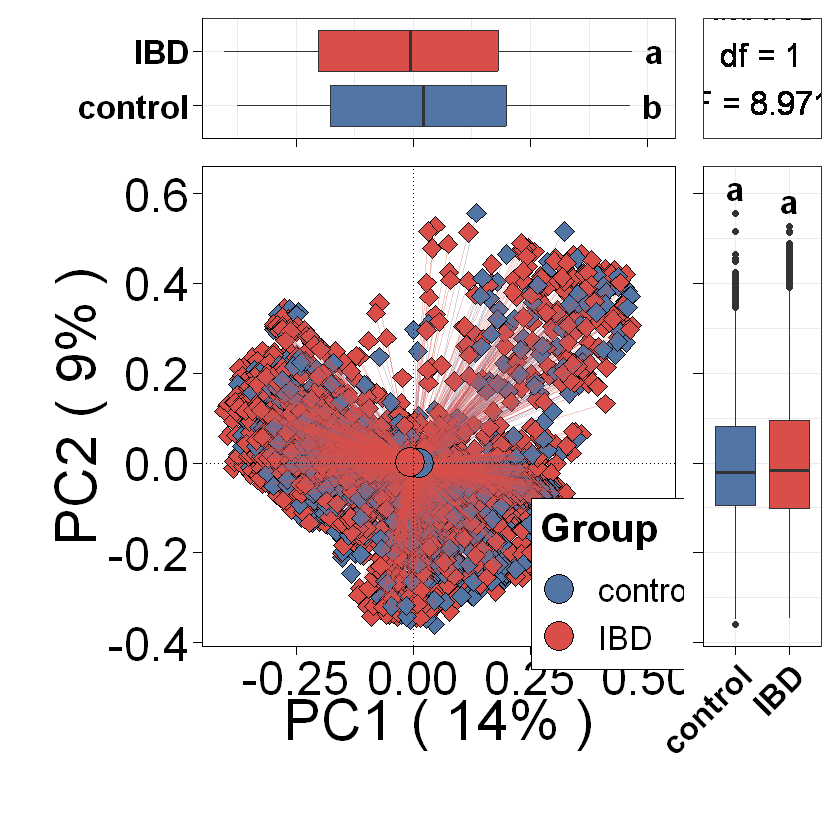

In [10]:
p4 <- ggplot(yf, aes(PC1, PC2)) +
  geom_text(aes(x = -0.5,y = 0.6,label = paste("PERMANOVA:\ndf = ",otu.adonis0$Df[1],  "\nF = ",round(otu.adonis0$F[1],3),  "\np-value = ",otu.adonis0$`Pr(>F)`[1],sep = "")),
            size = 7) +
  theme_bw() +
  xlab("") + ylab("") +
  theme(panel.grid=element_blank(), 
        axis.title = element_blank(),
        axis.line = element_blank(),
        axis.ticks = element_blank(),
        axis.text = element_blank())

p5 <- p1 + p4 + p2 + p3 + 
  plot_layout(heights = c(1,4),widths = c(4,1),ncol = 2,nrow = 2)
p5
#pdf("Results/Results3/5.1 PCoA_controlCase.pdf",height=10,width=12)
#p5
#dev.off()


### matched cohorts

In [11]:
groups <- data.frame(V1=c(PSMlabel$Control,PSMlabel$Case),
                     V2=rep(c("control","IBD"),each=nrow(PSMlabel)))
matched_microdata<-data.frame(V1=rownames(microdata),microdata)
Mmicrodata<-join(groups,matched_microdata,match="first")
data <- vegdist(Mmicrodata[,-c(1,2)])
pcoa<- pcoa(data, correction = "none", rn = NULL)
PC1 = pcoa$vectors[,1]
PC2 = pcoa$vectors[,2]
plotdata <- data.frame(sample=groups$V1,PC1=PC1,PC2=PC2,Group=groups$V2)
#colnames(plotdata) <-c("sample","PC1","PC2","Group")
pc1 <-floor(pcoa$values$Relative_eig[1]*100)
pc2 <-floor(pcoa$values$Relative_eig[2]*100)
plotdata$Group <- factor(plotdata$Group,levels = c("control","IBD"))

Joining by: V1



In [12]:
yf2 <- plotdata
aggregate(yf2$PC1 , by=list(type=yf2$Group),mean)
aggregate(yf2$PC2 , by=list(type=yf2$Group),mean)
# yf2 %>% group_by(Group) %>% summarise(Mean = mean(PC1))
# yf2 %>% group_by(Group) %>% summarise(Mean = mean(PC2))
length(which(plotdata$Group=="control"))
plotdata$pair[which(plotdata$Group=="control")]<-1:2023
plotdata$pair[which(plotdata$Group=="IBD")]<-2024:4046
cp<-data.frame(sample="mean_control",
               PC1=-0.0136,PC2=-0.011,Group="control",
               pair=1:2023)
ip<-data.frame(sample="mean_ibd",
               PC1=0.0136,PC2=0.011,Group="IBD",
               pair=2024:4046)
plotdata<-rbind(plotdata,cp,ip)

yd3 <- yf2 %>% group_by(Group) %>% summarise(Max = max(PC1))
yd4 <- yf2 %>% group_by(Group) %>% summarise(Max = max(PC2))

yd3$Max <- yd3$Max + max(yd3$Max)*0.1
yd4$Max <- yd4$Max + max(yd4$Max)*0.1
fit1 <- aov(PC1~Group,data = yf2)
tuk1<-glht(fit1,linfct=mcp(Group="Tukey"))
res1 <- cld(tuk1,alpah=0.05)
fit2 <- aov(PC2~Group,data = yf2)
tuk2<-glht(fit2,linfct=mcp(Group="Tukey"))
res2 <- cld(tuk2,alpah=0.05)
test <- data.frame(PC1 = res1$mcletters$Letters,PC2 = res2$mcletters$Letters,
                   yd3 = yd3$Max,yd4 = yd4$Max,Group = yd3$Group)
test$Group <- factor(test$Group,levels = c("control","IBD"))
cbbPalette=c("#5175A4","#D94E48")

type,x
<fct>,<dbl>
control,-0.01358165
IBD,0.01358165


type,x
<fct>,<dbl>
control,-0.01100768
IBD,0.01100768


[1] 2023

In [13]:
p1 <- ggplot(yf2,aes(Group,PC1)) +
  geom_boxplot(aes(fill = Group)) +
  geom_text(data = test,aes(x = Group,y = yd3,label = PC1),
            size = 7,color = "black",fontface = "bold") +
  coord_flip() +
  scale_fill_manual(values=cbbPalette) +
  theme_bw()+
  theme(axis.ticks.length = unit(0.4,"lines"), 
        axis.ticks = element_line(color='black'),
        axis.line = element_line(colour = "black"), 
        axis.title.x=element_blank(),
        axis.title.y=element_blank(),
        axis.text.y=element_text(colour='black',size=20,face = "bold"),
        axis.text.x=element_blank(),
        legend.position = "none")

p3 <- ggplot(yf2,aes(Group,PC2)) +
  geom_boxplot(aes(fill = Group)) +
  geom_text(data = test,aes(x = Group,y = yd4,label = PC2),
            size = 7,color = "black",fontface = "bold") +
  scale_fill_manual(values=cbbPalette) +
  theme_bw()+
  theme(axis.ticks.length = unit(0.4,"lines"), 
        axis.ticks = element_line(color='black'),
        axis.line = element_line(colour = "black"), 
        axis.title.x=element_blank(),
        axis.title.y=element_blank(),
        axis.text.x=element_text(colour='black',size=20,angle = 45,
                                 vjust = 1,hjust = 1,face = "bold"),
        axis.text.y=element_blank(),
        legend.position = "none")

hlpoint<-plotdata[c(4047,8092),]

p2<-ggplot(plotdata, aes(PC1, PC2)) +
  geom_point(aes(fill=Group),size=4,pch =23)+
  geom_line(aes(group = pair,color=Group),alpha=0.3) +
  geom_point(data=hlpoint,aes(fill=Group),size=8,pch =21)+
  scale_fill_manual(values=cbbPalette,name = "Group")+
  scale_colour_manual(values=cbbPalette,name = "Group")+
  xlab(paste("PC1 ( ",pc1,"%"," )",sep="")) + 
  ylab(paste("PC2 ( ",pc2,"%"," )",sep=""))+
  xlim(ggplot_build(p1)$layout$panel_scales_y[[1]]$range$range) +
  ylim(ggplot_build(p3)$layout$panel_scales_y[[1]]$range$range) +
  theme(text=element_text(size=30))+
  geom_vline(aes(xintercept = 0),linetype="dotted")+
  geom_hline(aes(yintercept = 0),linetype="dotted")+
  theme(panel.background = element_rect(fill='white', colour='black'),
        panel.grid=element_blank(), 
        axis.title = element_text(color='black',size=34),
        axis.ticks.length = unit(0.4,"lines"), axis.ticks = element_line(color='black'),
        axis.line = element_line(colour = "black"), 
        axis.title.x=element_text(colour='black', size=34,vjust = 7),
        axis.title.y=element_text(colour='black', size=34,vjust = -2),
        axis.text=element_text(colour='black',size=28),
        legend.title=element_text(size = 24,face = "bold"),
        legend.text=element_text(size=20),
        legend.key=element_blank(),legend.position = c(0.88,0.13),
        legend.background = element_rect(colour = "black"),
        legend.key.height=unit(1,"cm")) +
  guides(fill = guide_legend(ncol = 1))


otu.adonis=adonis2(data~V2,data = groups,distance = "bray")

p4 <- ggplot(yf2, aes(PC1, PC2)) +
  geom_text(aes(x = -0.5,y = 0.6,label = paste("PERMANOVA:\ndf = ",otu.adonis$Df[1],  "\nF = ",round(otu.adonis$F[1],3),  "\np-value = ",otu.adonis$`Pr(>F)`[1],sep = "")),
            size = 7) +
  theme_bw() +
  xlab("") + ylab("") +
  theme(panel.grid=element_blank(), 
        axis.title = element_blank(),
        axis.line = element_blank(),
        axis.ticks = element_blank(),
        axis.text = element_blank())

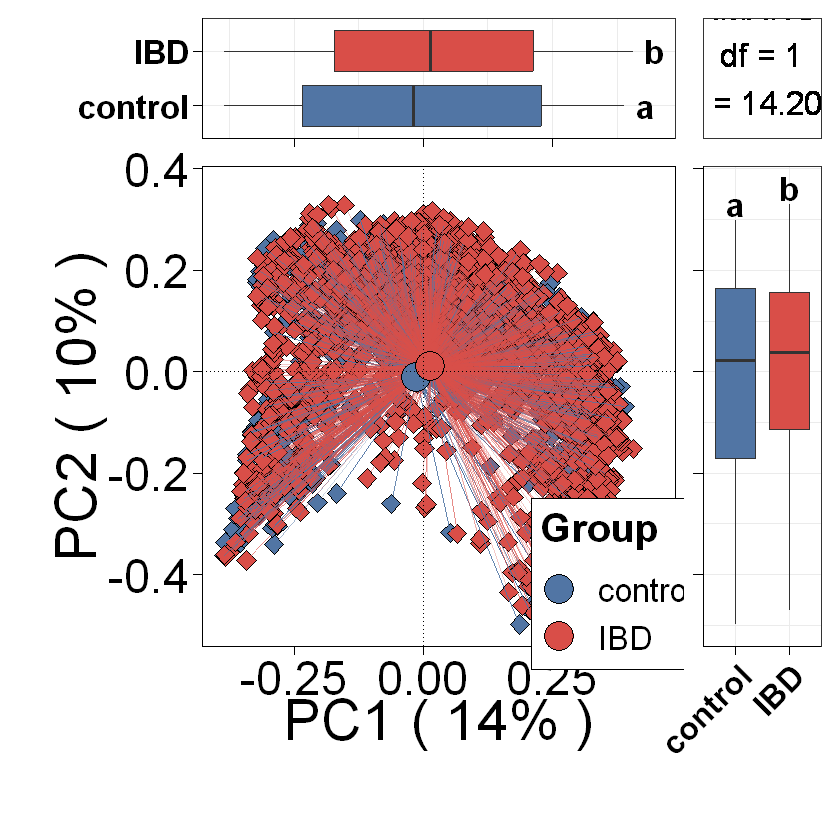

In [14]:
p5 <- p1 + p4 + p2 + p3 + 
  plot_layout(heights = c(1,4),widths = c(4,1),ncol = 2,nrow = 2)
p5
#pdf("Results/Results3/5.1 PCoA_controlCase_matched.pdf",height=10,width=12)
#p5
#dev.off()

## micro diff between female and male

### unmatched

In [15]:
metadata2<-read.csv("Temp/IBDMatchedMetadata.csv",stringsAsFactors = F)
gendermeta<-metadata2[,c(1,2,3,6)]
nalabel<-unique(gendermeta$ID[is.na(gendermeta$Gender)|(gendermeta$Gender=="")]) 
gendermeta$Gender[which(gendermeta$ID%in%nalabel)]=NA
table(gendermeta$study_condition,gendermeta$Gender)
gendermeta<-na.omit(gendermeta)
Gendergroup<-gendermeta %>% distinct(sample_id, .keep_all = TRUE)#按照sample_id unique数据框
Gendergroup<-Gendergroup[,c(2,4)]
GenderMicro<-microdata[which(rownames(microdata)%in%Gendergroup$sample_id),]
Gendergroup1<-data.frame(sample_id=rownames(GenderMicro))
Gendergroup<-join(Gendergroup1,Gendergroup,match="first")
colnames(Gendergroup) <- c("V1","V2")
genderData <- vegdist(GenderMicro)
pcoa<- pcoa(genderData, correction = "none", rn = NULL)
PC1 = pcoa$vectors[,1]
PC2 = pcoa$vectors[,2]
plotdata <- data.frame(rownames(pcoa$vectors),PC1,PC2,Gendergroup$V2)
colnames(plotdata) <-c("sample","PC1","PC2","Group")
pc1 <-floor(pcoa$values$Relative_eig[1]*100)
pc2 <-floor(pcoa$values$Relative_eig[2]*100)
plotdata$Group <- factor(plotdata$Group,levels = c("male","female"))

         
          female male
  control    607  731
  IBD        721  617

Joining by: sample_id



In [16]:
yf <- plotdata
yf %>% group_by(Group) %>% summarise(Mean = mean(PC1))
yf %>% group_by(Group) %>% summarise(Mean = mean(PC2))
length(which(plotdata$Group=="male"))
plotdata$pair<-0
plotdata$pair[which(plotdata$Group=="male")]<-1:842
plotdata$pair[which(plotdata$Group=="female")]<-843:1750
cp<-data.frame(sample="mean_male",
               PC1=0.00286,PC2=0.00372,Group="male",
               pair=1:842)
ip<-data.frame(sample="mean_female",
               PC1=-0.00265,PC2=-0.00345,Group="female",
               pair=843:1750)
plotdata<-rbind(plotdata,cp,ip)

hlpoint<-plotdata[c(1751,3500),]
gColor=c("#42B4E7","#e8a0b8")

Group,Mean
<fct>,<dbl>
male,0.002862725
female,-0.002654642


Group,Mean
<fct>,<dbl>
male,0.003719082
female,-0.003448752


[1] 842

,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
V2,1,1.451633,0.002836062,4.971536,0.001
Residual,1748,510.396519,0.997163938,NA,NA
Total,1749,511.848152,1.000000000,NA,NA


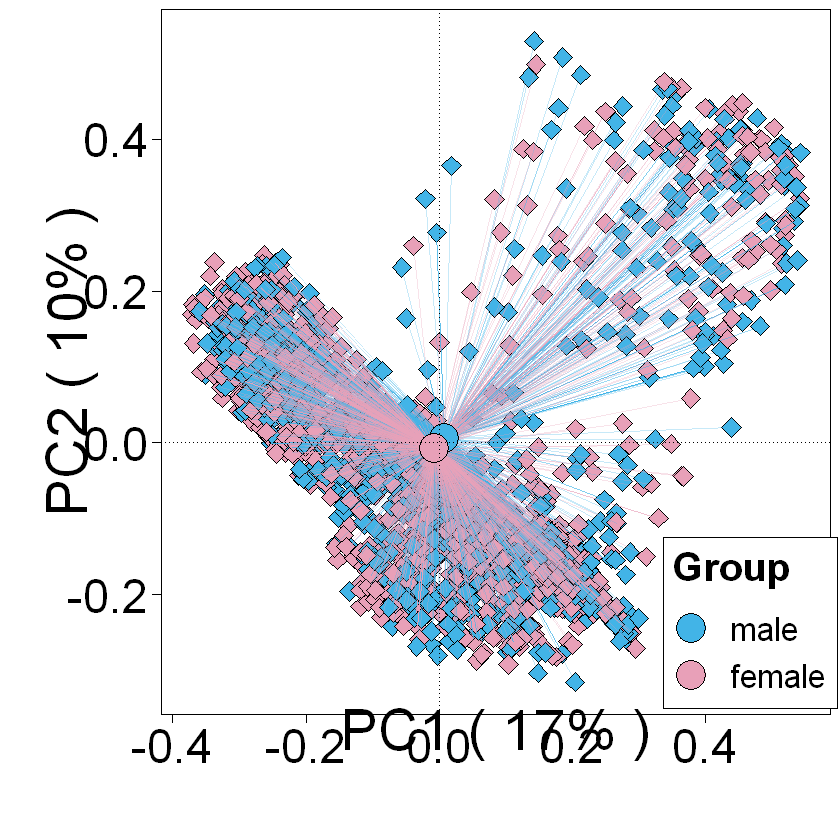

In [21]:
GenderP2<-ggplot(plotdata, aes(PC1, PC2)) +
          geom_point(aes(fill=Group),size=4,pch =23)+
          geom_line(aes(group = pair,color=Group),alpha=0.3) +
          geom_point(data=hlpoint,aes(fill=Group),size=8,pch =21)+
          scale_fill_manual(values=gColor,name = "Group")+
          scale_colour_manual(values=gColor,name = "Group")+
          xlab(paste("PC1 ( ",pc1,"%"," )",sep="")) + 
          ylab(paste("PC2 ( ",pc2,"%"," )",sep=""))+
#          xlim(ggplot_build(p1)$layout$panel_scales_y[[1]]$range$range) +
#          ylim(ggplot_build(p3)$layout$panel_scales_y[[1]]$range$range) +
          theme(text=element_text(size=30))+
          geom_vline(aes(xintercept = 0),linetype="dotted")+
          geom_hline(aes(yintercept = 0),linetype="dotted")+
          theme(panel.background = element_rect(fill='white', colour='black'),
                panel.grid=element_blank(), 
                axis.title = element_text(color='black',size=34),
                axis.ticks.length = unit(0.4,"lines"), axis.ticks = element_line(color='black'),
                axis.line = element_line(colour = "black"), 
                axis.title.x=element_text(colour='black', size=34,vjust = 7),
                axis.title.y=element_text(colour='black', size=34,vjust = -2),
                axis.text=element_text(colour='black',size=28),
                legend.title=element_text(size = 24,face = "bold"),
                legend.text=element_text(size=20),
                legend.key=element_blank(),legend.position = c(0.88,0.13),
                legend.background = element_rect(colour = "black"),
                legend.key.height=unit(1,"cm")) +
          guides(fill = guide_legend(ncol = 1))


otu.adonis=adonis2(genderData~V2,data = Gendergroup,distance = "bray")
otu.adonis

GenderP2
#pdf("Results/Results3/5.1 PCoA_gender_unmatched.pdf",height=10,width=12)
#GenderP2
#dev.off()


### matched

In [18]:
groups<-gendermeta[,c(2,4)]
colnames(groups) <- c("V1","V2")
GenderMicro$V1=rownames(GenderMicro)
MatchedMicro<-join(groups,GenderMicro,match="first")

MatchedData <- vegdist(MatchedMicro[,-c(1,2)])
pcoa<- pcoa(MatchedData, correction = "none", rn = NULL)
PC1 = pcoa$vectors[,1]
PC2 = pcoa$vectors[,2]
plotdata <- data.frame(groups$V1,PC1,PC2,groups$V2)
colnames(plotdata) <-c("sample","PC1","PC2","Group")
pc1 <-floor(pcoa$values$Relative_eig[1]*100)
pc2 <-floor(pcoa$values$Relative_eig[2]*100)
plotdata$Group <- factor(plotdata$Group,levels = c("male","female"))

yf <- plotdata
yf %>% group_by(Group) %>% summarise(Mean = mean(PC1))
yf %>% group_by(Group) %>% summarise(Mean = mean(PC2))
length(which(plotdata$Group=="male"))
plotdata$pair<-0
plotdata$pair[which(plotdata$Group=="male")]<-1:1348
plotdata$pair[which(plotdata$Group=="female")]<-1349:2676
cp<-data.frame(sample="mean_male",
               PC1=0.00786,PC2=0.00586,Group="male",
               pair=1:1348)
ip<-data.frame(sample="mean_female",
               PC1=-0.00798,PC2=-0.00798,Group="female",
               pair=1349:2676)
plotdata<-rbind(plotdata,cp,ip)

hlpoint<-plotdata[c(2677,5352),]
gColor=c("#42B4E7","#e8a0b8")

Joining by: V1



Group,Mean
<fct>,<dbl>
male,0.007860978
female,-0.007979366


Group,Mean
<fct>,<dbl>
male,0.005860950
female,-0.005949218


[1] 1348

,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
V2,1,2.347996,0.003032754,8.134254,0.001
Residual,2674,771.864394,0.996967246,NA,NA
Total,2675,774.212390,1.000000000,NA,NA


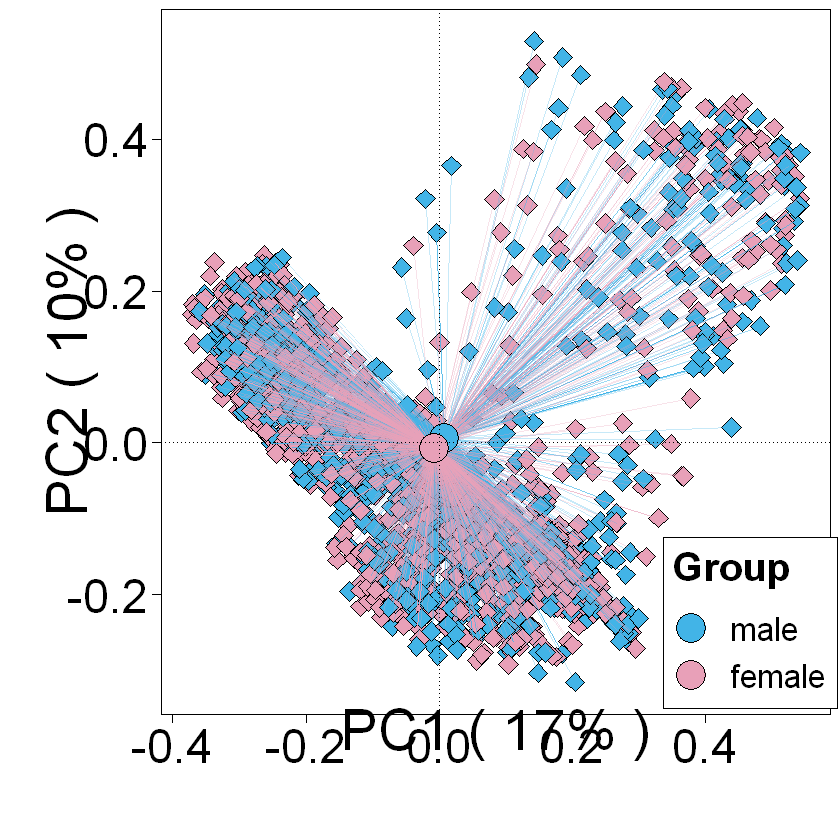

In [22]:
MatchP2<-ggplot(plotdata, aes(PC1, PC2)) +
  geom_point(aes(fill=Group),size=4,pch =23)+
  geom_line(aes(group = pair,color=Group),alpha=0.3) +
  geom_point(data=hlpoint,aes(fill=Group),size=8,pch =21)+
  scale_fill_manual(values=gColor,name = "Group")+
  scale_colour_manual(values=gColor,name = "Group")+
  xlab(paste("PC1 ( ",pc1,"%"," )",sep="")) + 
  ylab(paste("PC2 ( ",pc2,"%"," )",sep=""))+
# xlim(ggplot_build(p1)$layout$panel_scales_y[[1]]$range$range) +
# ylim(ggplot_build(p3)$layout$panel_scales_y[[1]]$range$range) +
  theme(text=element_text(size=30))+
  geom_vline(aes(xintercept = 0),linetype="dotted")+
  geom_hline(aes(yintercept = 0),linetype="dotted")+
  theme(panel.background = element_rect(fill='white', colour='black'),
        panel.grid=element_blank(), 
        axis.title = element_text(color='black',size=34),
        axis.ticks.length = unit(0.4,"lines"), axis.ticks = element_line(color='black'),
        axis.line = element_line(colour = "black"), 
        axis.title.x=element_text(colour='black', size=34,vjust = 7),
        axis.title.y=element_text(colour='black', size=34,vjust = -2),
        axis.text=element_text(colour='black',size=28),
        legend.title=element_text(size = 24,face = "bold"),
        legend.text=element_text(size=20),
        legend.key=element_blank(),legend.position = c(0.88,0.13),
        legend.background = element_rect(colour = "black"),
        legend.key.height=unit(1,"cm")) +
  guides(fill = guide_legend(ncol = 1))


otu.adonis=adonis2(MatchedData~V2,data = groups,distance = "bray")
otu.adonis
# PERMANOVA
# Df = 1
# R2 = 0.00303
# F = 8.1343
# P = 0.001
MatchP2
#pdf("Results/Results3/5.1 PCoA_gender_matched.pdf",height=10,width=12)
#MatchP2
#dev.off()

## micro diff in Countries

### unmatched

In [23]:
Countrymeta<-metadata2[,c(1,2,3,7)]
#table(Countrymeta$study_condition,Countrymeta$Country)
Countrygroup<-Countrymeta %>% distinct(sample_id, .keep_all = TRUE)#按照sample_id unique数据框
Countrygroup<-Countrygroup[,c(2,4)]
#table(Countrygroup$V2)
CountryMicro<-microdata[which(rownames(microdata)%in%Countrygroup$sample_id),]
group1<-data.frame(sample_id=rownames(CountryMicro))
Countrygroup<-join(group1,Countrygroup,match="first")
colnames(Countrygroup) <- c("V1","V2")
table(Countrygroup$V2)
CountryData <- vegdist(CountryMicro)
pcoa<- pcoa(CountryData, correction = "none", rn = NULL)
PC1 = pcoa$vectors[,1]
PC2 = pcoa$vectors[,2]
cplotdata <- data.frame(Countrygroup$V1,PC1,PC2,Countrygroup$V2)
colnames(cplotdata) <-c("sample","PC1","PC2","Group")
pc1 <-floor(pcoa$values$Relative_eig[1]*100)
pc2 <-floor(pcoa$values$Relative_eig[2]*100)

cplotdata$Group <- factor(cplotdata$Group,levels = c("CHN","DNK","ESP","GBR","USA"))

Joining by: sample_id




 CHN  DNK  ESP  GBR  USA 
   6   48  266   58 1781 

In [24]:
yf <- cplotdata
yf %>% group_by(Group) %>% summarise(Mean = mean(PC1))
yf %>% group_by(Group) %>% summarise(Mean = mean(PC2))
length(which(cplotdata$Group=="USA"))
cplotdata$pair<-0
cplotdata$pair[which(cplotdata$Group=="CHN")]<-1:6
cplotdata$pair[which(cplotdata$Group=="DNK")]<-7:54
cplotdata$pair[which(cplotdata$Group=="ESP")]<-55:320
cplotdata$pair[which(cplotdata$Group=="GBR")]<-321:378
cplotdata$pair[which(cplotdata$Group=="USA")]<-379:2159

c1<-data.frame(sample="mean_CHN",
               PC1=0.0419,PC2=0.0504,Group="CHN",
               pair=1:6)
c2<-data.frame(sample="mean_DNK",
               PC1=0.00537,PC2=-0.0202,Group="DNK",
               pair=7:54)
c3<-data.frame(sample="mean_ESP",
               PC1=0.0374,PC2=-0.0362,Group="ESP",
               pair=55:320)
c4<-data.frame(sample="mean_GBR",
               PC1=-0.00215,PC2=-0.0417,Group="GBR",
               pair=321:378)
c5<-data.frame(sample="mean_USA",
               PC1=-0.0058,PC2=0.00713,Group="USA",
               pair=379:2159)
cplotdata<-rbind(cplotdata,c1,c2,c3,c4,c5)

hlpoint<-cplotdata[c(2160,2167,2479,2480,4318),]
cColor=c("#D24317","#E9972F","#a696c8","#94D1C6","#2F8DAE")

Group,Mean
<fct>,<dbl>
CHN,0.041896421
DNK,0.005368581
ESP,0.037389041
GBR,-0.002154333
USA,-0.005799890


Group,Mean
<fct>,<dbl>
CHN,0.050359424
DNK,-0.020200364
ESP,-0.036153025
GBR,-0.041745022
USA,0.007133844


[1] 1781

,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
V2,4,28.34705,0.04176342,23.46978,0.001
Residual,2154,650.40602,0.95823658,NA,NA
Total,2158,678.75307,1.00000000,NA,NA


Warning message:
"Removed 90 rows containing missing values (`geom_point()`)."
Warning message:
"Removed 90 rows containing missing values (`geom_line()`)."


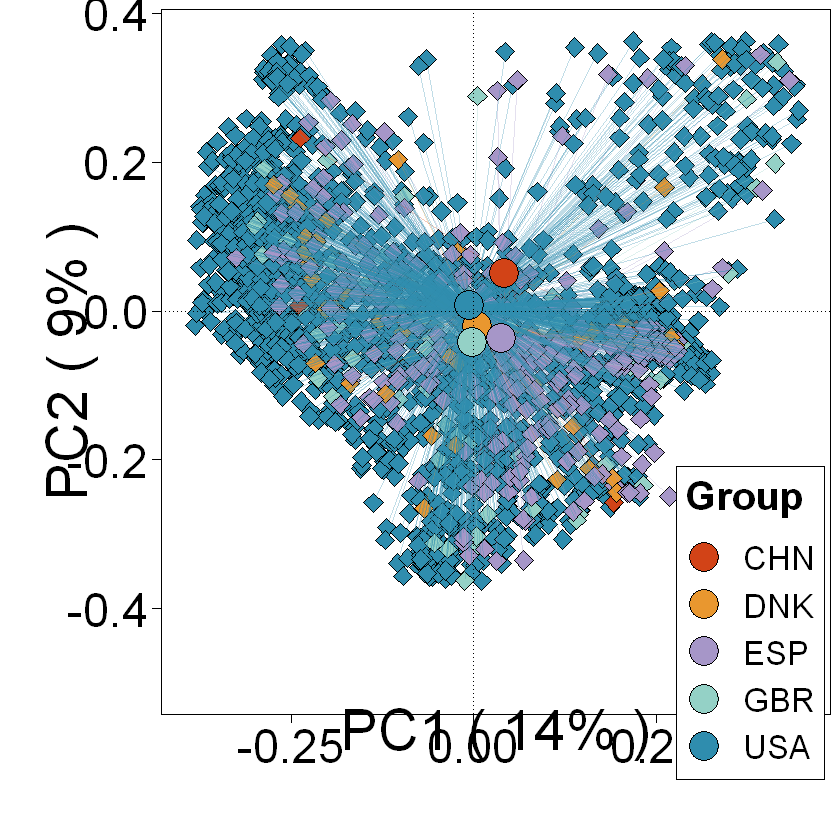

In [25]:
CP2<-ggplot(cplotdata, aes(PC1, PC2)) +
  geom_point(aes(fill=Group),size=4,pch =23)+
  geom_line(aes(group = pair,color=Group),alpha=0.3) +
  geom_point(data=hlpoint,aes(fill=Group),size=8,pch =21)+
  scale_fill_manual(values=cColor,name = "Group")+
  scale_colour_manual(values=cColor,name = "Group")+
  xlab(paste("PC1 ( ",pc1,"%"," )",sep="")) + 
  ylab(paste("PC2 ( ",pc2,"%"," )",sep=""))+
  xlim(ggplot_build(p1)$layout$panel_scales_y[[1]]$range$range) +
  ylim(ggplot_build(p3)$layout$panel_scales_y[[1]]$range$range) +
  theme(text=element_text(size=30))+
  geom_vline(aes(xintercept = 0),linetype="dotted")+
  geom_hline(aes(yintercept = 0),linetype="dotted")+
  theme(panel.background = element_rect(fill='white', colour='black'),
        panel.grid=element_blank(), 
        axis.title = element_text(color='black',size=34),
        axis.ticks.length = unit(0.4,"lines"), axis.ticks = element_line(color='black'),
        axis.line = element_line(colour = "black"), 
        axis.title.x=element_text(colour='black', size=34,vjust = 7),
        axis.title.y=element_text(colour='black', size=34,vjust = -2),
        axis.text=element_text(colour='black',size=28),
        legend.title=element_text(size = 24,face = "bold"),
        legend.text=element_text(size=20),
        legend.key=element_blank(),legend.position = c(0.88,0.13),
        legend.background = element_rect(colour = "black"),
        legend.key.height=unit(1,"cm")) +
  guides(fill = guide_legend(ncol = 1))


country.adonis_unmatched=adonis2(CountryData~V2,data = Countrygroup,distance = "bray")
country.adonis_unmatched
# PERMANOVA
# Df = 4
# R2 = 0.04176
# F = 23.47
# P = 0.001
CP2
#pdf("Results/Results3/5.1 PCoA_Country.pdf",height=10,width=12)
#CP2
#dev.off()


### matched

In [26]:
cgroups<-Countrymeta[,c(2,4)]
colnames(cgroups) <- c("V1","V2")
CountryMicro$V1=rownames(CountryMicro)
cMatchedMicro<-join(cgroups,CountryMicro,match="first")

cMatchedData <- vegdist(cMatchedMicro[,-c(1,2)])
pcoa<- pcoa(cMatchedData, correction = "none", rn = NULL)
PC1 = pcoa$vectors[,1]
PC2 = pcoa$vectors[,2]
cplotdata <- data.frame(cgroups$V1,PC1,PC2,cgroups$V2)
colnames(cplotdata) <-c("sample","PC1","PC2","Group")
pc1 <-floor(pcoa$values$Relative_eig[1]*100)
pc2 <-floor(pcoa$values$Relative_eig[2]*100)


cplotdata$Group <- factor(cplotdata$Group,levels = c("CHN","DNK","ESP","GBR","USA"))


Joining by: V1



In [27]:
yf <- cplotdata
yf %>% group_by(Group) %>% summarise(Mean = mean(PC1))
yf %>% group_by(Group) %>% summarise(Mean = mean(PC2))
table(cplotdata$Group)
cplotdata$pair<-0
cplotdata$pair[which(cplotdata$Group=="CHN")]<-1:97
cplotdata$pair[which(cplotdata$Group=="DNK")]<-98:183
cplotdata$pair[which(cplotdata$Group=="ESP")]<-184:514
cplotdata$pair[which(cplotdata$Group=="GBR")]<-515:622
cplotdata$pair[which(cplotdata$Group=="USA")]<-623:4046
c1<-data.frame(sample="mean_CHN",
               PC1=0.00396,PC2=0.102,Group="CHN",
               pair=1:97)
c2<-data.frame(sample="mean_DNK",
               PC1=0.0731,PC2=0.024,Group="DNK",
               pair=98:183)
c3<-data.frame(sample="mean_ESP",
               PC1=0.0156,PC2=0.0865,Group="ESP",
               pair=184:514)
c4<-data.frame(sample="mean_GBR",
               PC1=0.072,PC2=0.118,Group="GBR",
               pair=515:622)
c5<-data.frame(sample="mean_USA",
               PC1=-0.00572,PC2=-0.0156,Group="USA",
               pair=623:4046)
cplotdata<-rbind(cplotdata,c1,c2,c3,c4,c5)

hlpoint<-rbind(c1[1,],c2[1,],c3[1,],c4[1,],c5[1,])
cColor=c("#D24317","#E9972F","#a696c8","#94D1C6","#2F8DAE")

Group,Mean
<fct>,<dbl>
CHN,0.003957378
DNK,0.073073094
ESP,0.015564358
GBR,0.072015574
USA,-0.005723609


Group,Mean
<fct>,<dbl>
CHN,0.10207182
DNK,0.02401001
ESP,0.08648226
GBR,0.11815004
USA,-0.01558168



 CHN  DNK  ESP  GBR  USA 
  97   86  331  108 3424 

,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
V2,4,50.27508,0.03650331,38.27462,0.001
Residual,4041,1326.99947,0.96349669,NA,NA
Total,4045,1377.27455,1.00000000,NA,NA


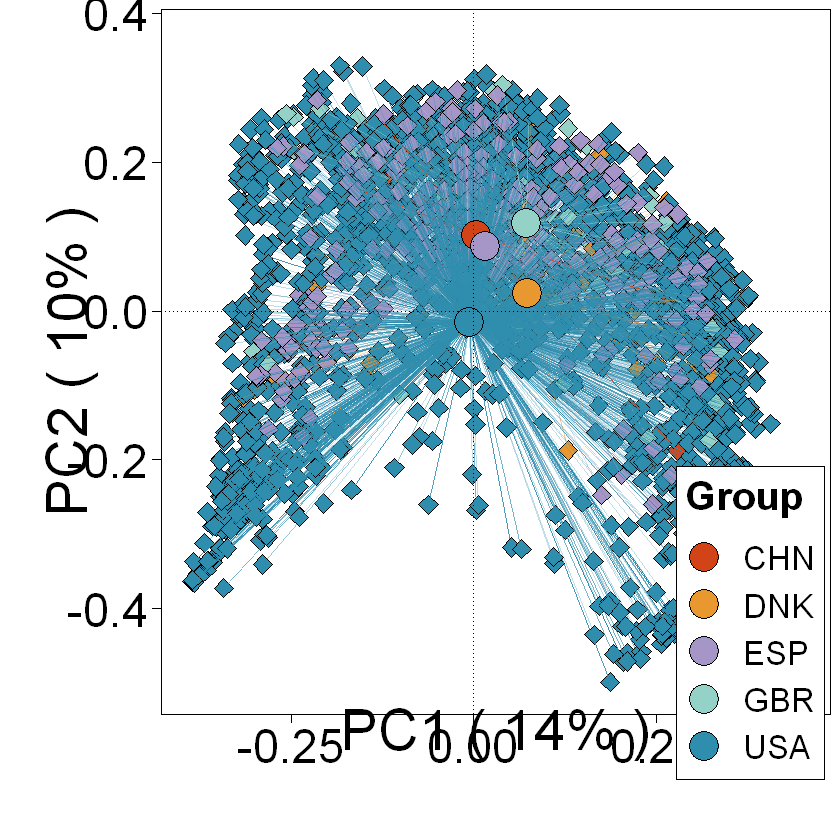

In [28]:
MCP2<-ggplot(cplotdata, aes(PC1, PC2)) +
  geom_point(aes(fill=Group),size=4,pch =23)+
  geom_line(aes(group = pair,color=Group),alpha=0.3) +
  geom_point(data=hlpoint,aes(fill=Group),size=8,pch =21)+
  scale_fill_manual(values=cColor,name = "Group")+
  scale_colour_manual(values=cColor,name = "Group")+
  xlab(paste("PC1 ( ",pc1,"%"," )",sep="")) + 
  ylab(paste("PC2 ( ",pc2,"%"," )",sep=""))+
  xlim(ggplot_build(p1)$layout$panel_scales_y[[1]]$range$range) +
  ylim(ggplot_build(p3)$layout$panel_scales_y[[1]]$range$range) +
  theme(text=element_text(size=30))+
  geom_vline(aes(xintercept = 0),linetype="dotted")+
  geom_hline(aes(yintercept = 0),linetype="dotted")+
  theme(panel.background = element_rect(fill='white', colour='black'),
        panel.grid=element_blank(), 
        axis.title = element_text(color='black',size=34),
        axis.ticks.length = unit(0.4,"lines"), axis.ticks = element_line(color='black'),
        axis.line = element_line(colour = "black"), 
        axis.title.x=element_text(colour='black', size=34,vjust = 7),
        axis.title.y=element_text(colour='black', size=34,vjust = -2),
        axis.text=element_text(colour='black',size=28),
        legend.title=element_text(size = 24,face = "bold"),
        legend.text=element_text(size=20),
        legend.key=element_blank(),legend.position = c(0.88,0.13),
        legend.background = element_rect(colour = "black"),
        legend.key.height=unit(1,"cm")) +
  guides(fill = guide_legend(ncol = 1))


country.adonis_matched=adonis2(cMatchedData~V2,data = cgroups,distance = "bray")
country.adonis_matched
# PERMANOVA
# Df = 4
# R2 = 0.0365
# F = 38.275
# P = 0.001
MCP2
#pdf("Results/Results3/5.1 PCoA_Country_matched.pdf",height=10,width=12)
#MCP2
#dev.off()